# Support Vector Machines (SVM) & Kernel Trick - From Scratch (with SciPy Optimizer)

This unified tutorial is inspired by:
- Kaggle: *SVM with Kernel Trick from Scratch*
- GeeksforGeeks: *Implementing SVM and Kernel SVM with scikit-learn*
- MachineLearningMastery: *Kernel Methods in Python*
- QuarkML blog: *SVM kernels (polynomial, RBF)*

We will:

1. Implement the **dual formulation** of a soft-margin SVM using NumPy.
2. Use **SciPy's optimizer** to solve the dual problem (instead of writing SMO ourselves).
3. Implement the **kernel trick** via linear and RBF kernels.
4. Compare accuracy and decision boundaries of **linear vs RBF kernels** on `make_circles`.


## Learning objectives

By the end of this tutorial, you should be able to:

- Write down the soft-margin SVM **dual objective** and constraints.
- Implement **kernel functions** (linear, RBF) and Gram matrices in NumPy.
- Use **SciPy** to solve the constrained quadratic optimization problem for SVM.
- Visualize and compare linear vs RBF SVMs on a non-linearly separable dataset.


In [1]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from scipy.optimize import minimize

plt.rcParams['figure.figsize'] = (6, 4)
np.set_printoptions(precision=4, suppress=True)


## 1) Toy dataset: non-linear circles

We use `make_circles` so that:

- linear SVM fails to separate the classes well,
- RBF SVM succeeds thanks to the kernel trick.


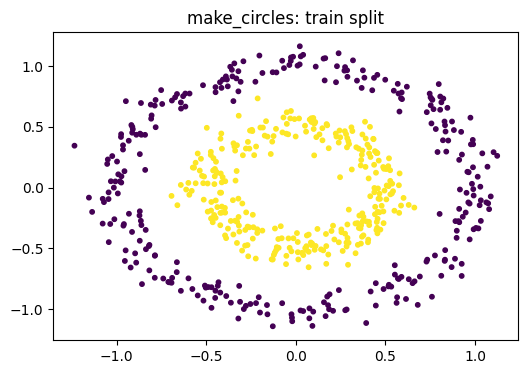

In [2]:
X, y = make_circles(n_samples=800, factor=0.5, noise=0.08, random_state=0)
y = np.where(y == 1, 1, -1)  # convert labels to {-1, +1}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10)
plt.title("make_circles: train split")
plt.show()


## 2) Kernels

Implement the **linear** and **RBF** kernels and a helper to compute the Gram matrix.

We will use:

- Linear:  \(K(x,z) = x^\top z\)
- RBF:     \(K(x,z) = \exp(-\gamma \|x - z\|^2)\)


In [3]:
def linear_kernel(X1, X2):
    """Return linear kernel Gram matrix K_ij = <x_i, z_j>."""
    return X1 @ X2.T


def rbf_kernel(X1, X2, gamma: float):
    """Return RBF kernel Gram matrix K_ij = exp(-gamma ||x_i - z_j||^2)."""
    X1_sq = np.sum(X1**2, axis=1)[:, None]
    X2_sq = np.sum(X2**2, axis=1)[None, :]
    cross = X1 @ X2.T

    dists_sq = X1_sq + X2_sq - 2 * cross
    return np.exp(-gamma * dists_sq)


def compute_gram(X1, X2, kernel: str = "linear", gamma: float = 1.0):
    """Compute Gram matrix for the given kernel type."""
    if kernel == "linear":
        return linear_kernel(X1, X2)
    elif kernel == "rbf":
        return rbf_kernel(X1, X2, gamma)
    else:
        raise ValueError(f"Unknown kernel type: {kernel}")


## 3) Dual SVM with SciPy optimizer

We consider the soft-margin SVM dual:

\begin{align}
\max_{\alpha} \quad &
  \sum_{i=1}^N \alpha_i - \frac{1}{2} \sum_{i,j=1}^N \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
\text{s.t.} \quad & 0 \le \alpha_i \le C, \quad \forall i \\
                  & \sum_{i=1}^N \alpha_i y_i = 0
\end{align}

We will:

1. Precompute the **Gram matrix** \\(K\\).
2. Precompute \\(Q_{ij} = y_i y_j K_{ij}\\).
3. Define the **objective** to *minimize* (negative of the dual).
4. Use `scipy.optimize.minimize` with:
   - bounds `0 <= alpha_i <= C`,
   - equality constraint `sum(alpha_i * y_i) = 0`.


In [4]:
class SVMFromScratch:
    def __init__(self, C=1.0, kernel="linear", gamma=1.0, random_state=0):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.random_state = random_state

        self.X = None
        self.y = None
        self.alphas = None
        self.b = 0.0

    def fit(self, X, y):
        """Fit SVM by solving the dual with SciPy's optimizer."""
        self.X = X
        self.y = y.astype(float)
        N = X.shape[0]

        # Gram matrix
        K = compute_gram(X, X, kernel=self.kernel, gamma=self.gamma)
        # Q_ij = y_i y_j K_ij
        Q = (self.y[:, None] * self.y[None, :]) * K

        def objective(alpha):
            # 0.5 * alpha^T Q alpha - 1^T alpha  (to MINIMIZE)
            alpha = alpha.reshape(-1, 1)
            return 0.5 * float(alpha.T @ Q @ alpha) - float(alpha.sum())


        def objective_grad(alpha):
            # gradient: Q alpha - 1
            return (Q @ alpha) - np.ones_like(alpha)

        # Equality constraint: sum_i alpha_i y_i = 0
        constraints = ({
            "type": "eq",
            "fun": lambda a: np.dot(a, self.y),
            "jac": lambda a: self.y
        },)

        bounds = [(0, self.C) for _ in range(N)]
        alpha0 = np.zeros(N)

        res = minimize(
            fun=objective,
            x0=alpha0,
            jac=objective_grad,
            bounds=bounds,
            constraints=constraints,
            method="SLSQP",
            options={"maxiter": 500, "ftol": 1e-6, "disp": False},
        )

        self.alphas = res.x

        # Compute bias term b using support vectors with 0 < alpha_i < C
        sv_mask = (self.alphas > 1e-6) & (self.alphas < self.C - 1e-6)
        if not np.any(sv_mask):
            # Fallback: just use any non-zero alpha
            sv_mask = self.alphas > 1e-6

        idx = np.where(sv_mask)[0]
        if idx.size == 0:
            self.b = 0.0
        else:
            # b = y_i - sum_j alpha_j y_j K_ij, averaged over SVs
            b_vals = []
            for i in idx:
                s = np.sum(self.alphas * self.y * K[i])
                b_vals.append(self.y[i] - s)
            self.b = float(np.mean(b_vals))

        return self

    def decision_function(self, X_new):
        """Compute f(x) = sum_i alpha_i y_i K(x_i, x) + b."""
        K_new = compute_gram(self.X, X_new, kernel=self.kernel, gamma=self.gamma)
        w = self.alphas * self.y
        return w @ K_new + self.b

    def predict(self, X_new):
        """Return predicted labels in {-1, +1}."""
        return np.sign(self.decision_function(X_new))


## 4) Train & compare: Linear vs RBF on `make_circles`

Now we:

1. Train **linear SVM** and evaluate on test set.
2. Train **RBF SVM** and evaluate on test set.
3. Plot decision boundaries for both.


In [5]:
def plot_decision_boundary(model, X, y, title="Decision boundary"):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2, levels=[-1, 0, 1])
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.title(title)
    plt.show()


/tmp/ipython-input-1727774419.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 0.5 * float(alpha.T @ Q @ alpha) - float(alpha.sum())


Linear kernel accuracy: 0.510


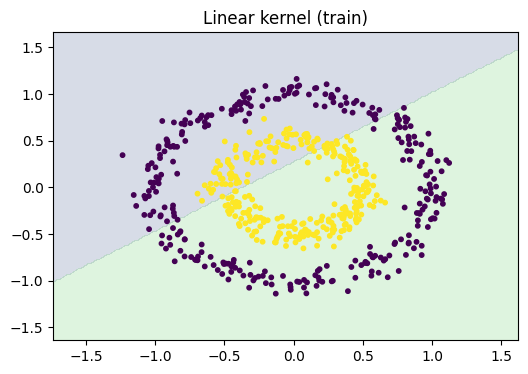

In [6]:
# TODO: Train and evaluate linear SVM
svm_lin = SVMFromScratch(C=1.0, kernel="linear").fit(X_train, y_train)
y_pred_lin = svm_lin.predict(X_test)
acc_lin = accuracy_score(y_test, y_pred_lin)
print(f"Linear kernel accuracy: {acc_lin:.3f}")
plot_decision_boundary(svm_lin, X_train, y_train, title="Linear kernel (train)")


/tmp/ipython-input-1727774419.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 0.5 * float(alpha.T @ Q @ alpha) - float(alpha.sum())


RBF kernel accuracy: 1.000


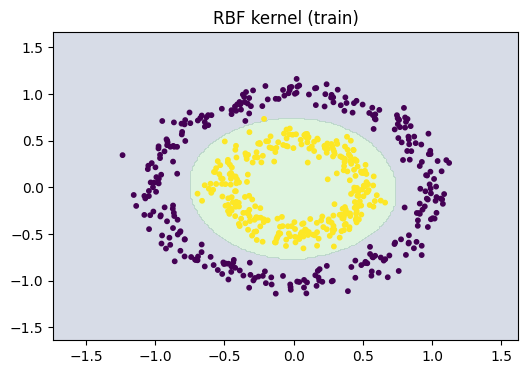

In [7]:
# TODO: Train and evaluate RBF SVM (e.g., gamma=2.0)
svm_rbf = SVMFromScratch(C=1.0, kernel="rbf", gamma=2.0).fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
acc_rbf = accuracy_score(y_test, y_pred_rbf)
print(f"RBF kernel accuracy: {acc_rbf:.3f}")
plot_decision_boundary(svm_rbf, X_train, y_train, title="RBF kernel (train)")


## 5) Discussion

In a short markdown cell (your own words):

- How do linear vs RBF accuracies differ on `make_circles`? Why?
- How does the **gamma** parameter of the RBF kernel affect the decision boundary?
- What are the pros/cons of solving SVM via a generic optimizer (SciPy) vs specialized SMO implementations (like in scikit-learn)?


Датасет make_circles складається з двох концентричних кіл. У двовомірному просторі неможливо провести пряму лінію, яка б відділила внутішнє коло від зовнішнього. Ядро RBF неявно відображає дані у простір, де ці два класи стають лінійно роздільними гіперплощиною.

Мале значення gamma: рішення стає більш гладким, є ризик недонавчання.
Велике значення gamma: межа класифікації вигинається сильніше навколо окремих точок, можливе перенавчання.

*SciPy*

"+" легко реалізувати, гнучкість - легко змінити ядро

"-" повільний для великих даних, потребує налаштування параметрів

*SMO *

"+" швидкий для великих наборів даних, стабільний

"-" складна реалізація